In [1]:
from rec.models.mnist_vae import MNISTVAE
from rec.core.utils import setup_logger

import tensorflow as tf
tfl = tf.keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import logging

In [2]:
save_dir = "../../../../models/relative-entropy-coding/snis-experiments/gaussian"

In [3]:
gauss_vae = MNISTVAE(name="gaussian_mnist_vae", prior=tfd.Normal(loc=tf.zeros(50), scale=tf.ones(50)))

ckpt = tf.train.Checkpoint(model=gauss_vae)

manager = tf.train.CheckpointManager(ckpt, save_dir, max_to_keep=3)

gauss_vae(tf.zeros([1, 28, 28, 1]))
status = ckpt.restore(manager.latest_checkpoint)

if manager.latest_checkpoint:
    print(f"Restored {manager.latest_checkpoint}")

Restored ../../../../models/relative-entropy-coding/snis-experiments/gaussian/ckpt-36


In [4]:
dataset = tfds.load("binarized_mnist",
                    data_dir="/scratch/gf332/datasets/binarized_mnist")

test_ds = dataset["test"]

test_ds = test_ds.map(lambda x: tf.cast(x["image"], tf.float32))

tf.Tensor(-130.9443, shape=(), dtype=float32)


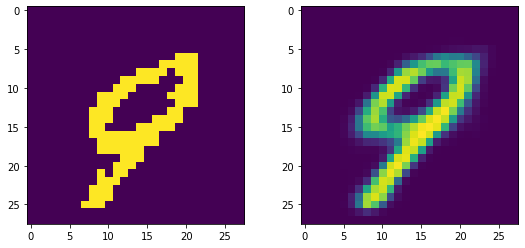

In [19]:
K = 1

for i in test_ds.take(1):
    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.imshow(i[..., 0])
    plt.subplot(122)
    plt.imshow(gauss_vae(i[None, ...])[0,...,0])
    
    samples = tf.reshape(gauss_vae.posterior.sample(K), [K, -1])
    
    post_prob = gauss_vae.posterior.log_prob(samples)
    post_prob = tf.reduce_sum(post_prob, axis=1)
    
    prior_prob = gauss_vae.prior.log_prob(samples)
    prior_prob = tf.reduce_sum(prior_prob, axis=1)
    
    likelihood_loc = gauss_vae.decoder(samples)
    likelihood_dist = tfd.Bernoulli(probs=tf.clip_by_value(likelihood_loc, 1e-9, 1 - 1e-9))
    
#     plt.figure(figsize=(13, 4))
#     plt.subplot(131)
#     plt.imshow(likelihood_loc[0, :, :, 0])
#     plt.subplot(132)
#     plt.imshow(likelihood_loc[1, ..., 0])
#     plt.subplot(133)
#     plt.imshow(likelihood_loc[2, ..., 0])
    
    likelihood = likelihood_dist.log_prob(i)
    likelihood = tf.einsum("ijkl -> i", likelihood)

    log_weights = prior_prob + likelihood - post_prob
    
    log_lik = tf.reduce_logsumexp(log_weights)
    log_lik = log_lik - tf.math.log(tf.cast(K, tf.float32))
    
    print(log_lik)

In [16]:
tf.reduce_max(tf.abs(likelihood_loc - i))

<tf.Tensor: id=2271, shape=(), dtype=float32, numpy=0.95485604>

In [12]:
likelihood_loc[0, 0, 0, 0]

<tf.Tensor: id=2070, shape=(), dtype=float32, numpy=0.0>

In [13]:
tf.reduce_mean(gauss_vae.posterior.scale)

<tf.Tensor: id=774, shape=(), dtype=float32, numpy=0.70812285>

In [3]:
gauss_vae = MNISTVAE(prior=tfd.Normal(loc=tf.zeros(50), scale=tf.ones(50)))

In [28]:
gauss_vae(tf.zeros([30, 28, 28, 1]), training=True)

emp_kl = tf.reduce_mean(gauss_vae.kl_divergence)
actual_kl = tf.reduce_mean(tfd.kl_divergence(gauss_vae.posterior, gauss_vae.prior))

print(emp_kl)
print(actual_kl)

(30, 50)
(30, 50)
tf.Tensor(0.11504004, shape=(), dtype=float32)
tf.Tensor(0.10673923, shape=(), dtype=float32)
